## Implementing a CycleGAN

We will implement CycleGAN using PyTorch. We will train a model to translate images of apples to oranges and vice versa.

The CycleGAN model is composed of two generators and two discriminators. The generators are responsible for translating images from one domain to another, while the discriminators are responsible for distinguishing between translated images and real images. The generators and discriminators are trained in an adversarial manner, where the generators try to fool the discriminators and the discriminators try to distinguish between real and fake images. You can see an overview of the CycleGAN model in the figure below:
<img src="https://junyanz.github.io/CycleGAN/images/cyclegan_blogs.jpg">

You can refer to the [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) for more information.

Retrieve the *apple2orange* dataset from the following URL [http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/apple2orange.zip](http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/apple2orange.zip) decompress it in the *datasets* directory

You can also just execute the following cell:

In [ ]:
!wget -N http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/apple2orange.zip -O ./datasets/apple2orange.zip
!mkdir ./datasets/apple2orange
!unzip apple2orange.zip -d ./datasets/
!rm apple2orange.zip

### 1) Dataset creation

In [1]:
import os
import gc
import random
import tqdm
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from PIL import Image
from torch.optim import lr_scheduler
from IPython.display import clear_output
from torch.utils.data import Subset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device used : {device}')

Device used : cuda


Some useful functions that we will use later:

In [3]:
def denormalize(images, std=0.5, mean=0.5):
    # For plot
    images = (images * std) + mean
    return images

def deprocess(input_tensor):
    if len(input_tensor.shape) == 3:
        return np.transpose(denormalize(input_tensor.to(device).cpu()), (1, 2, 0))
    elif len(input_tensor.shape) == 4:
        return np.transpose(denormalize(input_tensor.to(device).cpu()), (0, 2, 3, 1))

We will now implement a simple dataset class in order to load the images. The dataset class should load the images from the dataset folder and apply the input transformations

In [5]:
class GeneratorDataset(data.Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.filenames = np.array([filename for filename in os.listdir(root_dir)])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.root_dir, self.filenames[idx])).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

We will now create the dataset objects for the training and testing sets:

In [6]:
DATASET = 'apple2orange'
DATASET_PATH = os.path.join("datasets", DATASET) # Dataset path
OUTPUT_PATH = 'outputs'
base_logdir = os.path.join("logs", 'pytorch') # Sets up a log directory.
RESIZE_SHAPE = 128 # Resized image size for faster training

# Create the dataset objects
preprocess_train_transformations = transforms.Compose([
                               transforms.Resize(RESIZE_SHAPE),
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

preprocess_test_transformations = transforms.Compose([
                               transforms.Resize(RESIZE_SHAPE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

train_data_X = GeneratorDataset(root_dir=os.path.join(DATASET_PATH, "trainA"),
                           transform=preprocess_train_transformations)

train_data_Y = GeneratorDataset(root_dir=os.path.join(DATASET_PATH, "trainB"),
                           transform=preprocess_train_transformations)

test_data_X = GeneratorDataset(root_dir=os.path.join(DATASET_PATH, "testA"),
                           transform=preprocess_test_transformations)

test_data_Y = GeneratorDataset(root_dir=os.path.join(DATASET_PATH, "testB"),
                           transform=preprocess_test_transformations)

print("Found {} images in {}".format(len(train_data_X), 'trainA'))
print("Found {} images in {}".format(len(train_data_Y), 'trainB'))
print("Found {} images in {}".format(len(test_data_X), 'testA'))
print("Found {} images in {}".format(len(test_data_Y), 'testB'))

Found 995 images in trainA
Found 1019 images in trainB
Found 266 images in testA
Found 248 images in testB


In order to speed up the training process, we will use a subset of the training data:

In [7]:
random.seed(42)

N_IMAGES_TO_SAMPLE = 400

indices_X = random.sample(range(len(train_data_X)), N_IMAGES_TO_SAMPLE)
indices_Y = random.sample(range(len(train_data_Y)), N_IMAGES_TO_SAMPLE)

train_data_X = Subset(train_data_X, indices_X)
train_data_Y = Subset(train_data_Y, indices_Y)

### 2) Generator and Discriminator Models

We will now implement the backbone for the generator and the discriminator.

In [8]:
##############################
#           RESNET
##############################


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.res = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.res(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_channel, n_blocks, filters, output_channel):
        super(GeneratorResNet, self).__init__()

        # Initial convolution block
        model = [
            nn.ReflectionPad2d(input_channel),
            nn.Conv2d(input_channel, filters, 7),
            nn.InstanceNorm2d(filters),
            nn.ReLU(inplace=True),
        ]
        in_features = filters

        # Downsampling
        for _ in range(2):
            filters *= 2
            model += [
                nn.Conv2d(in_features, filters, 3, stride=2, padding=1),
                nn.InstanceNorm2d(filters),
                nn.ReLU(inplace=True),
            ]
            in_features = filters

        # Residual blocks
        for _ in range(n_blocks):
            model += [ResidualBlock(filters)]

        # Upsampling
        for _ in range(2):
            filters //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, filters, 3, stride=1, padding=1),
                nn.InstanceNorm2d(filters),
                nn.ReLU(inplace=True),
            ]
            in_features = filters

        # Output layer
        model += [nn.ReflectionPad2d(output_channel), nn.Conv2d(filters, output_channel, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    def __init__(self, input_channel, filters):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(input_channel, filters, normalize=False),
            *discriminator_block(filters, filters * 2),
            *discriminator_block(filters * 2, filters * 4),
            *discriminator_block(filters * 4, filters *8),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(filters *8, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

We will now instantiate the generator and discriminator models:

In [9]:
G_XtoY = GeneratorResNet(input_channel=3, output_channel=3, filters=64, n_blocks=9).to(device)
G_YtoX = GeneratorResNet(input_channel=3, output_channel=3, filters=64, n_blocks=9).to(device)

In [10]:
Dx = Discriminator(input_channel=3, filters=64).to(device)
Dy = Discriminator(input_channel=3, filters=64).to(device)

We will now implement a function to randomly initialize the weights for all the convolutional layers in the generators and the discriminators with values sampled from a normal distribution (mean=0.0, std=0.02), and initialize their bias to 0.0.

In [11]:
def weights_init_normal(m):
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
    elif isinstance(m, nn.InstanceNorm2d):
        if m.weight is not None:
            nn.init.normal_(m.weight.data, mean=1.0, std=0.02)
        if m.bias is not None:
            nn.init.constant(m.bias.data, 0.0)

# ============================
# Initialize the values of the models
# ============================
# Initialize the values of the two generators
G_XtoY.apply(weights_init_normal)
G_YtoX.apply(weights_init_normal)
# Initialize the values of the two discriminators
Dx.apply(weights_init_normal)
Dy.apply(weights_init_normal)
print()

### 3) Training

We will define the hyperparameters used for training our CycleGAN model. The model should run on the T4 GPU provided by Google Colab or any other GPU at disposal. You may need to adjust the batch size to fit the model on other GPUs. I trained it here on my RTX 3060 Ti with 8 GB of VRAM.

In [12]:
BATCH_SIZE = 10
EPOCHs = 10
SAVE_EVERY_N_EPOCH = 1
LR = 0.0002
BETAS = (0.5, 0.999)

We will now define the data loaders for the training and testing sets:

In [13]:
train_image_loader_X = torch.utils.data.DataLoader(train_data_X, batch_size=BATCH_SIZE,
                                                    shuffle=True, num_workers=0)
train_image_loader_Y = torch.utils.data.DataLoader(train_data_Y, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=0)
test_image_loader_X = torch.utils.data.DataLoader(test_data_X, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)
test_image_loader_Y = torch.utils.data.DataLoader(test_data_Y, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)

We will now extract some images from the test set to visualize the model's performance during training:

In [14]:
id_sample_X = np.where(test_data_X.filenames == "n07740461_11391.jpg")[0][0]
id_sample_Y = np.where(test_data_Y.filenames == "n07749192_10081.jpg")[0][0]
sample_X = test_data_X[id_sample_X]
sample_Y = test_data_Y[id_sample_Y]
print(f"Sample X id:{id_sample_X}, Sample Y id: {id_sample_Y}")

Sample X id:22, Sample Y id: 0


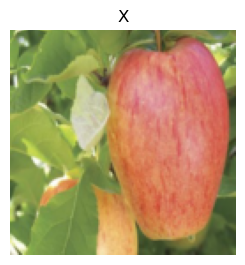

In [15]:
plt.subplot(121)
plt.title('X')
plt.axis('off')
plt.imshow(deprocess(sample_X))
plt.show()

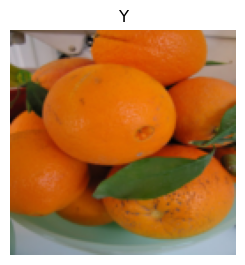

In [16]:
plt.subplot(121)
plt.title('Y')
plt.axis('off')
plt.imshow(deprocess(sample_Y))
plt.show()

Now let's define the optimizers and schedulers for the generator and discriminator models.

In [17]:
G_XtoY_optimizer = torch.optim.Adam(G_XtoY.parameters(), lr=LR, betas=BETAS)
G_YtoX_optimizer = torch.optim.Adam(G_YtoX.parameters(), lr=LR, betas=BETAS)
Dx_optimizer = torch.optim.Adam(Dx.parameters(), lr=LR, betas=BETAS)
Dy_optimizer = torch.optim.Adam(Dy.parameters(), lr=LR, betas=BETAS)

def lr_lambda(epoch):
    return 1-max(0,epoch-EPOCHs//2)/(EPOCHs//2)

G_XtoY_scheduler = torch.optim.lr_scheduler.LambdaLR(G_XtoY_optimizer, lr_lambda=lr_lambda)
G_YtoX_scheduler = torch.optim.lr_scheduler.LambdaLR(G_YtoX_optimizer, lr_lambda=lr_lambda)
Dx_scheduler = torch.optim.lr_scheduler.LambdaLR(Dx_optimizer, lr_lambda=lr_lambda)
Dy_scheduler = torch.optim.lr_scheduler.LambdaLR(Dy_optimizer, lr_lambda=lr_lambda)

We will now implement the different loss functions used in CycleGANs:

In [18]:
SOFT_FAKE_LABEL_RANGE =  [0.0, 0.3] # The label of fake label will be generated within this range.
SOFT_REAL_LABEL_RANGE = [0.7, 1.2] # The label of real label will be generated within this range.

The discriminator loss is defined by:
\begin{equation}
\mathcal{L}_{D} = \frac{1}{2} (\mathbb{E}_{y \sim p_{data}(y)}[(D_Y(y) - r_2)^2] + \mathbb{E}_{x \sim p_{data}(x)}[(D_Y(G_{XY}(x))-r_1)^2]) + \frac{1}{2} (\mathbb{E}_{x \sim p_{data}(x)}[(D_X(x) - r_2)^2] + \mathbb{E}_{y \sim p_{data}(y)}[(D_X(G_{YX}(y))-r_1)^2])
\end{equation}
with $p_{data}(x)$ being the distribution of images from the first domain, $p_{data}(y)$ being the distribution of images from the second domain, $G_{XY}$ and $G_{YX}$ being the two generators, $D_X$ and $D_Y$ the two discriminators, and $r_1$ and $r_2$ being the soft fake and real labels chosen from a uniform distribution within the ranges $[0.0, 0.3]$ and $[0.7, 1.2]$ respectively.

In [19]:
def discriminator_loss(discriminator, real_image, generated_image):
    #Discriminators output
    pred_real = discriminator(real_image) 
    pred_fake = discriminator(generated_image.detach()) 

    # Calculate the losses 
    loss_real = F.mse_loss(pred_real, torch.tensor(random.uniform(0.7, 1.2), device=device).expand_as(discriminator(real_image)))  # Real images loss
    loss_fake = F.mse_loss(pred_fake, torch.tensor(random.uniform(0.0, 0.3), device=device).expand_as(discriminator(generated_image)))  # Fake images loss

    # Combine the losses
    loss = 0.5 * (loss_real + loss_fake)
    return loss

The generator loss is defined by:
\begin{equation}
\mathcal{L}_{G} = \mathbb{E}_{x \sim p_{data}(x)}(D_Y(G_{XY}(x)) - r_2)^2 + \mathbb{E}_{y \sim p_{data}(y)}(D_X(G_{YX}(y)) - r_2)^2
\end{equation}
with $p_{data}(x)$ being the distribution of images from the first domain, $p_{data}(y)$ being the distribution of images from the second domain, $G_{XY}$ and $G_{YX}$ being the two generators, $D_X$ and $D_Y$ the two discriminators, and $r_2$ being the soft real label chosen from a uniform distribution within the range $[0.7, 1.2]$.

In [20]:
def generator_loss(discriminator, generated_image):
    pred_real = torch.tensor(random.uniform(*SOFT_REAL_LABEL_RANGE), device=device).expand_as(discriminator(generated_image))

    pred_fake = discriminator(generated_image)

    loss = F.mse_loss(pred_fake, pred_real)
    return loss

In addition to the traditional loss functions used in GANs, CycleGANs also use two additional loss functions: cycle consistency loss and identity loss. We will use the same $\lambda$ for the two losses.

In [21]:
LAMBDA = 10

The cycle consistency loss is defined by:
\begin{equation}
\mathcal{L}_{cyc} = \lambda\mathbb{E}_{x \sim p_{data}(x)}[||x - G_{YX}(G_{XY}(x))||_1] + \lambda\mathbb{E}_{y \sim p_{data}(y)}[||y - G_{XY}(G_{YX}(y))||_1]
\end{equation}
with $p_{data}(x)$ being the distribution of images from the first domain, $p_{data}(y)$ being the distribution of images from the second domain, $G_{XY}$ and $G_{YX}$ being the two generators and $\lambda$ being the weight for the cycle consistency loss.

In [22]:
def cycle_consistency_loss(real_image, cycled_image):
    loss = LAMBDA * F.l1_loss(real_image, cycled_image)
    return loss

The identity loss is defined by:
\begin{equation}
\mathcal{L}_{id} = \frac{1}{2}\lambda\mathbb{E}_{x \sim p_{data}(x)}[||G_{YX}(x) - x||_1] + \frac{1}{2}\lambda\mathbb{E}_{y \sim p_{data}(y)}[||G_{XY}(y) - y||_1]
\end{equation}
with $p_{data}(x)$ being the distribution of images from the first domain, $p_{data}(y)$ being the distribution of images from the second domain, $G_{XY}$ and $G_{YX}$ being the two generators, and $\lambda$ being the weight for the identity loss.

In [23]:
def identity_loss(real_image, generated_image):
    loss = 0.5 * LAMBDA * F.l1_loss(generated_image, real_image)
    return loss

The total generator loss is defined by:
\begin{equation}
\mathcal{L}_{G_{tot}} = \mathcal{L}_{G} + \mathcal{L}_{cyc} + \mathcal{L}_{id}
\end{equation}
with $\mathcal{L}_{G_X}$ and $\mathcal{L}_{G_Y}$ being the generator loss for the two domains, $\mathcal{L}_{cyc}$ being the cycle consistency loss and $\mathcal{L}_{id}$ being the identity loss.

We will now set the checkpoint path for saving the model:

In [24]:
checkpoint_path = os.path.join("checkpoints", 'pytorch', DATASET, )

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

def save_training_checkpoint(epoch):
    state_dict = {
    'G_XtoY':G_XtoY.state_dict(),
    'G_YtoX':G_YtoX.state_dict(),
    'Dx':Dx.state_dict(),
    'Dy':Dy.state_dict(),
    'G_XtoY_optimizer':G_XtoY_optimizer.state_dict(),
    'G_YtoX_optimizer':G_YtoX_optimizer.state_dict(),
    'Dx_optimizer':Dx_optimizer.state_dict(),
    'Dy_optimizer':Dy_optimizer.state_dict(),
    'epoch': epoch
    }

    save_path = os.path.join(checkpoint_path, 'training-checkpoint')
    torch.save(state_dict, save_path)

# if a checkpoint exists, restore the latest checkpoint.
if os.path.isfile(os.path.join(checkpoint_path, 'training-checkpoint')):
    checkpoint = torch.load(os.path.join(checkpoint_path, 'training-checkpoint'))
    G_XtoY.load_state_dict(checkpoint['G_XtoY'])
    G_YtoX.load_state_dict(checkpoint['G_YtoX'])
    Dx.load_state_dict(checkpoint['Dx'])
    Dy.load_state_dict(checkpoint['Dy'])
    G_XtoY_optimizer.load_state_dict(checkpoint['G_XtoY_optimizer'])
    G_YtoX_optimizer.load_state_dict(checkpoint['G_YtoX_optimizer'])
    Dx_optimizer.load_state_dict(checkpoint['Dx_optimizer'])
    Dy_optimizer.load_state_dict(checkpoint['Dy_optimizer'])
    CURRENT_EPOCH = checkpoint['epoch']
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

C:\Users\ismoi\AppData\Local\Temp\ipykernel_25880\4146478379.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(checkpoint_path, 'trai

Latest checkpoint of epoch 3 restored!!


We need to implement a function to generate in the other modality a given *test_input* image using a trained generator:

In [25]:
def generate_images(model, test_input):
    model.eval()
    with torch.no_grad():
        generated_image = model(test_input.to(device))
    return denormalize(generated_image)

Now let's train the model:

In [26]:
training_steps = np.ceil((min(len(train_data_X), len(train_data_Y)) / BATCH_SIZE)).astype(int)

for epoch in range(1, EPOCHs + 1):
    print('Start of epoch %d' % (epoch,))
    # Reset dataloader
    iter_train_image_X = iter(train_image_loader_X)
    iter_train_image_Y = iter(train_image_loader_Y)
    # Initialize losses
    G_XtoY_loss_mean = 0
    G_YtoX_loss_mean = 0
    Dx_loss_mean = 0
    Dy_loss_mean = 0
    for step in range(training_steps):

        real_image_X = next(iter_train_image_X).to(device)
        real_image_Y = next(iter_train_image_Y).to(device)

        # ============================
        # Compute the discriminator loss
        # ============================
        # Generate fake images for discriminators
        fake_image_Y = G_XtoY(real_image_X)
        fake_image_X = G_YtoX(real_image_Y)


        # Compute the discriminator loss using the latest fake images
        Dx_loss = discriminator_loss(Dx, real_image_X, fake_image_X.detach())
        Dy_loss = discriminator_loss(Dy, real_image_Y, fake_image_Y.detach())

        # ============================
        # Update discriminators
        # ============================
        Dx_optimizer.zero_grad()
        Dy_optimizer.zero_grad()
        Dx_loss.backward()
        Dy_loss.backward()
        Dx_optimizer.step()
        Dy_optimizer.step()

        # ============================
        # Compute the generator loss
        # ============================
        # Generate fake images for generators
        fake_image_Y = G_XtoY(real_image_X)

        # Compute the generator loss using the latest fake images
        G_XtoY_loss = generator_loss(Dy, fake_image_Y)
        G_YtoX_loss = generator_loss(Dx, fake_image_X)

        # ============================
        # Compute the cycle consistency loss
        # ============================
        # Generate cycled images using the latest fake images
        cycled_image_Y = G_XtoY(fake_image_X)
        cycled_image_X = G_YtoX(fake_image_Y)

        # Compute the cycle consistency loss using the latest cycled images
        cycle_loss = cycle_consistency_loss(real_image_X, cycled_image_X) + cycle_consistency_loss(real_image_Y, cycled_image_Y)

        # ============================
        # Compute the identity loss
        # ============================
        # Generate identity images using the latest fake images
        identity_image_Y = G_XtoY(real_image_Y)
        identity_image_X = G_YtoX(real_image_X)
        # Compute the identity loss using the latest identity images
        id_loss = identity_loss(real_image_X, identity_image_X) + identity_loss(real_image_Y, identity_image_Y)

        # ============================
        # Combine all generator losses
        # ============================
        G_XtoY_loss_total = G_XtoY_loss + cycle_loss + id_loss
        G_YtoX_loss_total = G_YtoX_loss + cycle_loss + id_loss
        # ============================
        # Update generators
        # ============================
        G_XtoY_optimizer.zero_grad()
        G_YtoX_optimizer.zero_grad()
        G_XtoY_loss_total.backward(retain_graph=True)
        G_YtoX_loss_total.backward(retain_graph=True)
        G_XtoY_optimizer.step()
        G_YtoX_optimizer.step()

        # Add losses
        G_XtoY_loss_mean += G_XtoY_loss.item()
        G_YtoX_loss_mean += G_YtoX_loss.item()
        Dx_loss_mean += Dx_loss.item()
        Dy_loss_mean += Dy_loss.item()

        if step % 10 == 0:
            print ('.', end='')

    clear_output(wait=True)
    # ============================
    # Print loss values at the end of an epoch
    # ============================
    print(f"Epoch {epoch}:")
    print("Losses:")
    print(f"Generator X to Y: {G_XtoY_loss_mean / training_steps}")
    print(f"Generator Y to X: {G_YtoX_loss_mean / training_steps}")
    print(f"Discriminator X: {Dx_loss_mean / training_steps}")
    print(f"Discriminator Y: {Dy_loss_mean / training_steps}")


    # ============================
    # Save the checkpoint for every SAVE_EVERY_N_EPOCH epoch
    # ============================
    if epoch % SAVE_EVERY_N_EPOCH == 0:
        save_training_checkpoint(epoch=epoch)
        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             checkpoint_path))

    gc.collect()

Epoch 7:
Losses:
Generator X to Y: 0.3548826456069946
Generator Y to X: 0.32400608276948334
Discriminator X: 0.18140813745558262
Discriminator Y: 0.193243789114058
Saving checkpoint for epoch 7 at checkpoints\pytorch\apple2orange


### 4) Testing

Let's now generate images using the trained models : 

We will discuss on the results we got.

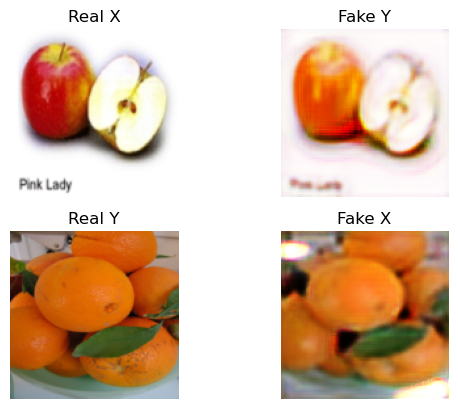

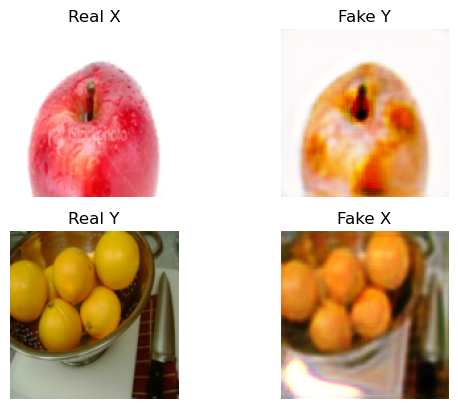

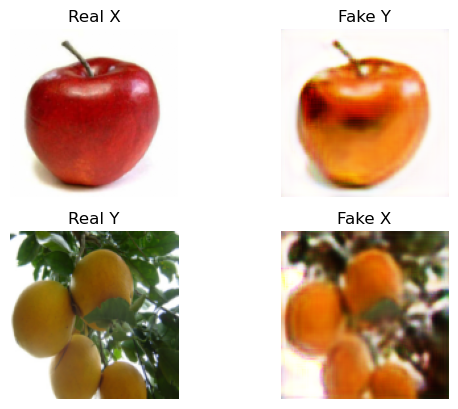

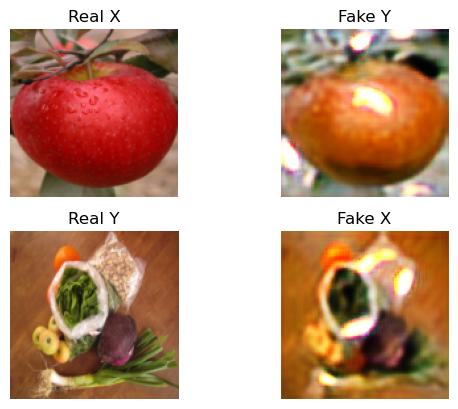

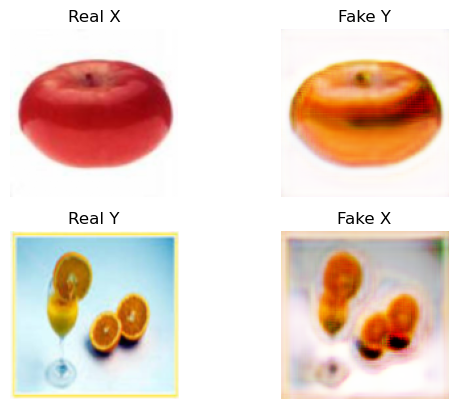

In [27]:
N=5

for i, X, Y in zip(range(N), test_image_loader_X, test_image_loader_Y):
    fig, axes = plt.subplots(2,2)
    real_X = X.to(device)
    real_Y = Y.to(device)
    fake_Y = generate_images(G_XtoY, real_X)
    fake_X = generate_images(G_XtoY, real_Y)
    axes[0][0].imshow(denormalize(real_X[0]).cpu().permute(1, 2, 0))
    axes[0][1].imshow(fake_Y[0].cpu().permute(1, 2, 0))
    axes[0][0].set_title("Real X")
    axes[0][1].set_title("Fake Y")
    axes[0][0].axis('off')
    axes[0][1].axis('off')
    axes[1][0].imshow(denormalize(real_Y[0]).cpu().permute(1, 2, 0))
    axes[1][1].imshow(fake_X[0].cpu().permute(1, 2, 0))
    axes[1][0].set_title("Real Y")
    axes[1][1].set_title("Fake X")
    axes[1][0].axis('off')
    axes[1][1].axis('off')


plt.show()

The key differences between a traditional GAN and a CycleGAN are that traditional GAN foceses on generating realistic data from random noise or a latent space (like creating images that look like a certain distribution) whereas CycleGAN does image to image translation between two domaines. The traditional GAN only uses one generator and one discriminator and the cycleGAN uses two generators (for each domain) and two discriminators (for each generators).

Also traditional GAN uses adversarial loss only to ensure the generator is realistic, and CycleGAN uses adversarial loss as well but with the cycle consistency loss that we saw earlier which ensures that the translation of an image back to its original domain results in the original image (the most).

It's through cycle consistency loss, "forward cycle-consistency" (cf. Cycle GAN paper) is when an image from X is translated to Y, the reconstructed image $G_{Y\text{to}X}(G_{X\text{to}Y}(x))\approx x$. 

And the "backward cycle-consistency" is defined similarly in the other way. an image from Y translated to X and back to Y should look like the original image in Y.

By minimizing the cycle consistency loss, the architecture maintains the key features of the original images during translation. Additionally adversarial losses from the discriminators ensure the translated images look realistic in their respective target domains.

Cycle consistency is crucial because it ensures that the translated image can be mapped back to its original domain without the loss of key features. It helps the model to learning meaningful and consistent mappings between two domains instead of not important transformations.

CycleGAN works without paired data, so the cycle loss is here to help the lack of supervised learning by providing a self supervised mechanism as explained in the paper.

Also in the paper they discover that without one direction of the cycle loss "it often incurs training instability and causes mode collapse, especially for the direction of the mapping that was removed."


### 5) Fine-Tuning
Let's fine tune the model on 1 epoch using skopt

In [ ]:
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer, Categorical

In [ ]:
dimensions = [
    Real(1e-5, 1e-1, prior="log-uniform", name="learning_rate"),
    Categorical([16, 32, 64, 128, 256], name="batch_size"),
    Categorical([3, 6, 9, 12], name="input_channel"),
    Categorical([3, 6, 9, 12], name="output_channel"),
    Categorical([16, 32, 64, 128], name="filters"),
    Integer(5,15, name="n_blocks")
]
parameters_default_values = [
    0.001, #lr
    32, #BATCHSIZE
    3, #input_channel
    3, #output_channel
    64, #filters
    9 #n_blocks
]
 # default value for each parameter for initialization

In [ ]:
@use_named_args(dimensions=dimensions)
def fit_opt(learning_rate, batch_size, input_channel, output_channel, filters, n_blocks):
    G_XtoY = GeneratorResNet(input_channel=input_channel, output_channel=output_channel, filters=filters, n_blocks=n_blocks).to(device)
    G_YtoX = GeneratorResNet(input_channel=input_channel, output_channel=output_channel, filters=filters, n_blocks=n_blocks).to(device)

    Dx = Discriminator(input_channel=input_channel, filters=filters).to(device)
    Dy = Discriminator(input_channel=input_channel, filters=filters).to(device)

    G_XtoY_optimizer = torch.optim.Adam(G_XtoY.parameters(), lr=learning_rate, betas=BETAS)
    G_YtoX_optimizer = torch.optim.Adam(G_YtoX.parameters(), lr=LR, betas=BETAS)
    Dx_optimizer = torch.optim.Adam(Dx.parameters(), lr=LR, betas=BETAS)
    Dy_optimizer = torch.optim.Adam(Dy.parameters(), lr=LR, betas=BETAS)

    def lr_lambda(epoch):
        return 1-max(0,epoch-EPOCHs//2)/(EPOCHs//2)

    G_XtoY_scheduler = torch.optim.lr_scheduler.LambdaLR(G_XtoY_optimizer, lr_lambda=lr_lambda)
    G_YtoX_scheduler = torch.optim.lr_scheduler.LambdaLR(G_YtoX_optimizer, lr_lambda=lr_lambda)
    Dx_scheduler = torch.optim.lr_scheduler.LambdaLR(Dx_optimizer, lr_lambda=lr_lambda)
    Dy_scheduler = torch.optim.lr_scheduler.LambdaLR(Dy_optimizer, lr_lambda=lr_lambda)

    train_image_loader_X = torch.utils.data.DataLoader(train_data_X, batch_size=batch_size,
                                                    shuffle=True, num_workers=0)
    train_image_loader_Y = torch.utils.data.DataLoader(train_data_Y, batch_size=batch_size,
                                            shuffle=True, num_workers=0)
    test_image_loader_X = torch.utils.data.DataLoader(test_data_X, batch_size=batch_size,
                                            shuffle=False, num_workers=0)
    test_image_loader_Y = torch.utils.data.DataLoader(test_data_Y, batch_size=batch_size,
                                            shuffle=False, num_workers=0)

    training_steps = np.ceil((min(len(train_data_X), len(train_data_Y)) / batch_size)).astype(int)

    print('Start of epoch %d' % (epoch,))
    # Reset dataloader
    iter_train_image_X = iter(train_image_loader_X)
    iter_train_image_Y = iter(train_image_loader_Y)
    # Initialize losses
    G_XtoY_loss_mean = 0
    G_YtoX_loss_mean = 0
    Dx_loss_mean = 0
    Dy_loss_mean = 0
    for step in range(training_steps):

        real_image_X = next(iter_train_image_X).to(device)
        real_image_Y = next(iter_train_image_Y).to(device)

        # ============================
        # Compute the discriminator loss
        # ============================
        # Generate fake images for discriminators
        fake_image_Y = G_XtoY(real_image_X)
        fake_image_X = G_YtoX(real_image_Y)


        # Compute the discriminator loss using the latest fake images
        Dx_loss = discriminator_loss(Dx, real_image_X, fake_image_X.detach())
        Dy_loss = discriminator_loss(Dy, real_image_Y, fake_image_Y.detach())

        # ============================
        # Update discriminators
        # ============================
        Dx_optimizer.zero_grad()
        Dy_optimizer.zero_grad()
        Dx_loss.backward()
        Dy_loss.backward()
        Dx_optimizer.step()
        Dy_optimizer.step()

        # ============================
        # Compute the generator loss
        # ============================
        # Generate fake images for generators
        fake_image_Y = G_XtoY(real_image_X)

        # Compute the generator loss using the latest fake images
        G_XtoY_loss = generator_loss(Dy, fake_image_Y)
        G_YtoX_loss = generator_loss(Dx, fake_image_X)

        # ============================
        # Compute the cycle consistency loss
        # ============================
        # Generate cycled images using the latest fake images
        cycled_image_Y = G_XtoY(fake_image_X)
        cycled_image_X = G_YtoX(fake_image_Y)

        # Compute the cycle consistency loss using the latest cycled images
        cycle_loss = cycle_consistency_loss(real_image_X, cycled_image_X) + cycle_consistency_loss(real_image_Y, cycled_image_Y)

        # ============================
        # Compute the identity loss
        # ============================
        # Generate identity images using the latest fake images
        identity_image_Y = G_XtoY(real_image_Y)
        identity_image_X = G_YtoX(real_image_X)
        # Compute the identity loss using the latest identity images
        id_loss = identity_loss(real_image_X, identity_image_X) + identity_loss(real_image_Y, identity_image_Y)

        # ============================
        # Combine all generator losses
        # ============================
        G_XtoY_loss_total = G_XtoY_loss + cycle_loss + id_loss
        G_YtoX_loss_total = G_YtoX_loss + cycle_loss + id_loss
        # ============================
        # Update generators
        # ============================
        G_XtoY_optimizer.zero_grad()
        G_YtoX_optimizer.zero_grad()
        G_XtoY_loss_total.backward(retain_graph=True)
        G_YtoX_loss_total.backward(retain_graph=True)
        G_XtoY_optimizer.step()
        G_YtoX_optimizer.step()

        # Add losses
        G_XtoY_loss_mean += G_XtoY_loss.item()
        G_YtoX_loss_mean += G_YtoX_loss.item()
        Dx_loss_mean += Dx_loss.item()
        Dy_loss_mean += Dy_loss.item()

        if step % 10 == 0:
            print ('.', end='')

    clear_output(wait=True)

    score = Dx_loss_mean + Dy_loss_mean + G_YtoX_loss_mean + G_XtoY_loss_mean

    return score

In [ ]:
gp_result = gp_minimize(
    func=fit_opt,            # Function to minimize
    dimensions=dimensions,   # Search space
    x0=parameters_default_values,
    n_calls=11,
    random_state=42,
    verbose=True
    )

print(f"Optimal set of parameters found at iteration {np.argmin(gp_result.func_vals)}")
print(gp_result.x)